In [14]:
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import cufflinks as cf
import plotly.graph_objs as go
import plotly.express as px

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
# Importing data from yahoo finance
import yfinance as yf
from plotly.subplots import make_subplots
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
import pandas_ta as ta
import sys

# Get Last 1 Month Every 5 Minutes (Get 1 Minute Data for 7 Days)

In [17]:
nf = yf.download(tickers ="NATCOPHARM.NS", period ="1mo", interval = "5m")
nf


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NATCOPHARM.NS,NATCOPHARM.NS,NATCOPHARM.NS,NATCOPHARM.NS,NATCOPHARM.NS
Datetime,,,,,
2025-04-01 03:45:00+00:00,804.299988,809.099976,798.250000,798.250000,0
2025-04-01 03:50:00+00:00,802.849976,809.650024,802.849976,804.500000,8514
2025-04-01 03:55:00+00:00,804.700012,805.849976,800.150024,802.900024,16571
2025-04-01 04:00:00+00:00,807.849976,809.450012,804.150024,804.450012,13823
2025-04-01 04:05:00+00:00,807.650024,809.000000,806.099976,807.500000,4754
...,...,...,...,...,...
2025-04-28 09:35:00+00:00,884.049988,884.599976,883.150024,884.250000,6101
2025-04-28 09:40:00+00:00,883.950012,884.700012,883.299988,884.000000,10338


# Plot a Candlestick Chart

C:\Users\91909\AppData\Local\Temp\ipykernel_7596\475340398.py:12: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



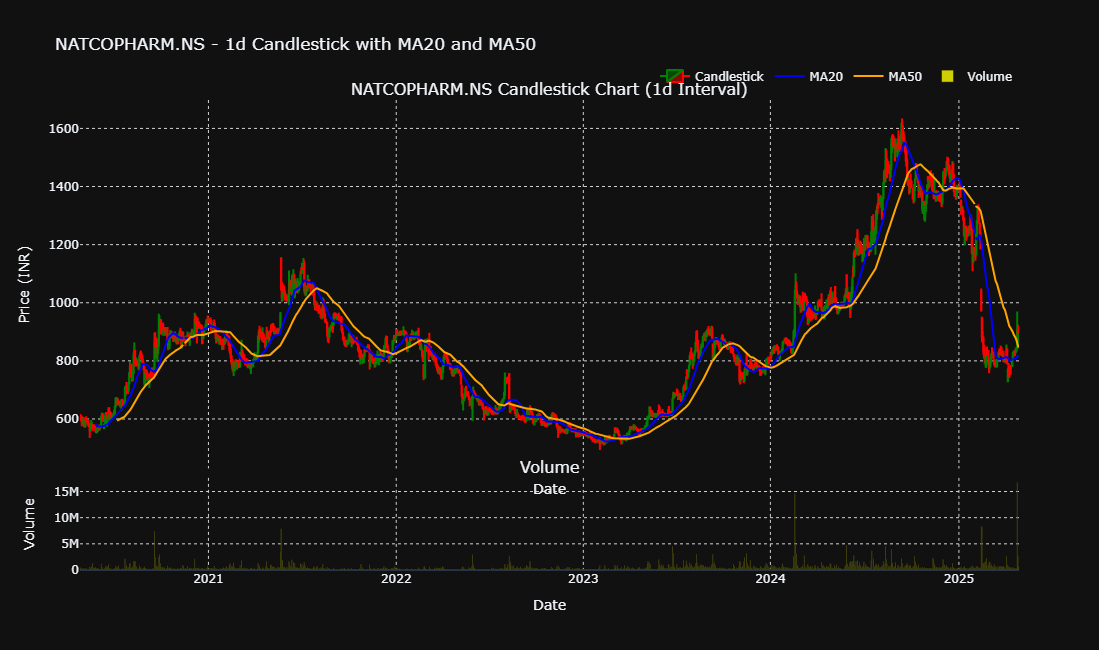

In [26]:
PATH = r"C:\Users\91909\Desktop\Stock_Data"

def save_to_csv_from_yahoo(ticker: str, interval: str = "1d") -> bool:
    df = yf.download(ticker, period="5y", interval=interval, progress=False)
    os.makedirs(PATH, exist_ok=True)
    fn = os.path.join(PATH, f"{ticker}_{interval}.csv")
    df.to_csv(fn)
    return True

def get_stock_df_from_csv(ticker: str, interval: str = "1d") -> pd.DataFrame:
    fn = os.path.join(PATH, f"{ticker}_{interval}.csv")
    df = pd.read_csv(fn, index_col=0, parse_dates=True)
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def plot_candlestick_with_volume(ticker: str, interval: str = "1d"):
    save_to_csv_from_yahoo(ticker, interval)
    df = get_stock_df_from_csv(ticker, interval)

    # Calculate 20-period Moving Average (MA)
    df['MA_20'] = df['Close'].rolling(window=20).mean()

    # Calculate 50-period Moving Average (MA)
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    # Create subplots (Candlestick + Volume)
    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02,
        row_width=[0.2, 0.8],
        subplot_titles=(f"{ticker} Candlestick Chart ({interval} Interval)", "Volume")
    )

    # Candlestick
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df["Open"], high=df["High"],
            low=df["Low"], close=df["Close"],
            name="Candlestick",
            increasing_line_color='green',
            decreasing_line_color='red'
        ),
        row=1, col=1
    )

    # Add 20-period Moving Average (MA)
    fig.add_trace(go.Scatter(x=df.index, y=df['MA_20'], line=dict(color='blue', width=2), name='MA20'), row=1, col=1)

    # Add 50-period Moving Average (MA)
    fig.add_trace(go.Scatter(x=df.index, y=df['MA_50'], line=dict(color='orange', width=2), name='MA50'), row=1, col=1)

    # Volume
    fig.add_trace(
        go.Bar(
            x=df.index, y=df["Volume"],
            marker_color='yellow',
            opacity=0.8,
            name="Volume"
        ),
        row=2, col=1
    )
    fig.update_xaxes(
        rangeslider_visible=False,
        rangebreaks=[dict(bounds=["sat", "mon"])],
        type="date",
        showgrid=True,
        gridcolor='lightgrey', 
        griddash='dot',     
        title_text='Date'
    )
    fig.update_yaxes(title="Price (INR)", row=1, col=1, showgrid=True, gridcolor='lightgrey', griddash='dot')
    fig.update_yaxes(title="Volume", row=2, col=1, showgrid=True, gridcolor='lightgrey', griddash='dot') 

    # Layout settings
    fig.update_layout(
        title=f'{ticker} - {interval} Candlestick with MA20 and MA50',
        yaxis_title='Price (INR)',
        template='plotly_dark',
        width=1100,
        height=650,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        hovermode='x unified'
    )

    fig.show()

# Example usage (using daily data):
plot_candlestick_with_volume("NATCOPHARM.NS", interval="1d")


# Download Multiple Stocks

In [29]:
stocks = ["APLLTD.NS", "BLUEJET.NS", "APLLTD.NS"]
stocks_df = yf.download(tickers=stocks, period='1mo', interval='5m')
stocks_df

[*********************100%***********************]  2 of 2 completed


Price                           Close                    High              \
Ticker                      APLLTD.NS  BLUEJET.NS   APLLTD.NS  BLUEJET.NS   
Datetime                                                                    
2025-04-01 03:45:00+00:00  910.000000  849.900024  916.250000  858.200012   
2025-04-01 03:50:00+00:00  906.849976  847.450012  912.750000  854.349976   
2025-04-01 03:55:00+00:00  910.950012  842.500000  910.950012  847.450012   
2025-04-01 04:00:00+00:00  911.750000  840.599976  913.549988  844.450012   
2025-04-01 04:05:00+00:00  911.700012  840.599976  914.700012  840.599976   
...                               ...         ...         ...         ...   
2025-04-28 09:35:00+00:00  869.950012  711.349976  870.299988  711.349976   
2025-04-28 09:40:00+00:00  870.400024  711.049988  870.500000  711.849976   
2025-04-28 09:45:00+00:00  871.849976  710.000000  872.599976  713.799988   
2025-04-28 09:50:00+00:00  871.549988  712.000000  873.450012  712.299988   
2025-04-28 09:55:00+00:00  870.700012  711.099976  873.250000  712.250000   

Price                             Low                    Open              \
Ticker                      APLLTD.NS  BLUEJET.NS   APLLTD.NS  BLUEJET.NS   
Datetime                                                                    
2025-04-01 03:45:00+00:00  909.900024  845.000000  915.049988  855.000000   
2025-04-01 03:50:00+00:00  906.849976  845.599976  909.950012  847.000000   
2025-04-01 03:55:00+00:00  904.049988  840.599976  906.799988  846.099976   
2025-04-01 04:00:00+00:00  908.200012  840.599976  908.200012  844.400024   
2025-04-01 04:05:00+00:00  911.200012  840.599976  911.950012  840.599976   
...                               ...         ...         ...         ...   
2025-04-28 09:35:00+00:00  868.099976  709.200012  869.049988  710.000000   
2025-04-28 09:40:00+00:00  868.750000  710.000000  870.000000  711.849976   
2025-04-28 09:45:00+00:00  870.250000  710.000000  870.400024  710.150024   
2025-04-28 09:50:00+00:00  871.200012  709.750000  871.900024  710.000000   
2025-04-28 09:55:00+00:00  870.049988  711.000000  872.349976  712.000000   

Price                        Volume             
Ticker                    APLLTD.NS BLUEJET.NS  
Datetime                                        
2025-04-01 03:45:00+00:00         0        0.0  
2025-04-01 03:50:00+00:00      1953    17710.0  
2025-04-01 03:55:00+00:00      2129    48150.0  
2025-04-01 04:00:00+00:00      1752     8359.0  
2025-04-01 04:05:00+00:00      2179     2979.0  
...                             ...        ...  
2025-04-28 09:35:00+00:00      1021     3668.0  
2025-04-28 09:40:00+00:00       910     1577.0  
2025-04-28 09:45:00+00:00      1774    12011.0  
2025-04-28 09:50:00+00:00      1176     6504.0  
2025-04-28 09:55:00+00:00      1192     4815.0  

[1271 rows x 10 columns]

# Simple Moving Average

In [32]:
# Download NATCOPHARM.NS,^CNXPHARMA and the ^NSEI
nf_df = yf.download(tickers='NATCOPHARM.NS', period='5y', interval='1d')
nf_df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NATCOPHARM.NS,NATCOPHARM.NS,NATCOPHARM.NS,NATCOPHARM.NS,NATCOPHARM.NS
Date,,,,,
2020-04-28,600.625793,617.384780,598.121604,609.197930,500780
2020-04-29,596.291626,611.509583,592.438991,608.716399,150631
2020-04-30,588.201050,606.790002,575.005763,605.826843,353892
2020-05-04,589.742065,606.597343,580.832847,588.489971,330977
2020-05-05,576.883850,604.863595,572.212496,592.824113,217642
...,...,...,...,...,...
2025-04-22,839.299988,843.799988,825.049988,834.400024,313748
2025-04-23,844.500000,847.750000,831.150024,840.000000,369205


In [34]:
ap_df = yf.download(tickers='APLLTD.NS', period='5y', interval='1d')
ap_df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,APLLTD.NS,APLLTD.NS,APLLTD.NS,APLLTD.NS,APLLTD.NS
Date,,,,,
2020-04-28,723.200684,792.639746,719.735886,792.639746,810649
2020-04-29,723.675293,744.226993,717.789871,725.668793,527204
2020-04-30,705.781616,754.668978,695.814290,734.734325,407025
2020-05-04,714.657227,735.114022,693.915720,703.408411,915796
2020-05-05,712.711182,743.277656,703.408357,724.244824,480970
...,...,...,...,...,...
2025-04-22,855.799988,861.400024,844.849976,855.799988,330940
2025-04-23,883.799988,908.200012,852.650024,859.799988,514590


In [36]:
nse_df = yf.download(tickers='^NSEI', period='5y', interval='1d')
nse_df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2020-04-28,9380.900391,9404.400391,9260.000000,9389.799805,614500
2020-04-29,9553.349609,9599.849609,9392.349609,9408.599609,653000
2020-04-30,9859.900391,9889.049805,9731.500000,9753.500000,931200
2020-05-04,9293.500000,9533.500000,9266.950195,9533.500000,687500
2020-05-05,9205.599609,9450.900391,9190.750000,9429.400391,725200
...,...,...,...,...,...
2025-04-22,24167.250000,24242.599609,24072.000000,24185.400391,440900
2025-04-23,24328.949219,24359.300781,24119.949219,24357.599609,415000


In [38]:
nf_ma20 = nf_df['Close'].rolling(window=20).mean()
nf_ma20.tail()

Ticker,NATCOPHARM.NS
Date,
2025-04-22,809.167496
2025-04-23,810.087497
2025-04-24,813.764996
2025-04-25,816.732495
2025-04-28,819.694995


In [40]:
ap_ma20 = ap_df['Close'].rolling(window=20).mean()
ap_ma20.tail()

Ticker,APLLTD.NS
Date,
2025-04-22,881.615005
2025-04-23,884.070004
2025-04-24,880.467505
2025-04-25,876.282504
2025-04-28,873.050006


In [42]:
nse_ma20 = nse_df['Close'].rolling(window=20).mean()
nse_ma20.tail()

Ticker,^NSEI
Date,
2025-04-22,23297.707422
2025-04-23,23354.622363
2025-04-24,23399.437305
2025-04-25,23418.487305
2025-04-28,23451.479785


# Calculate 100 Day Moving Average

In [45]:
# Allows us to study the averaged out long term trends
nf_ma100 = nf_df['Close'].rolling(window=100).mean()
ap_ma100 = ap_df['Close'].rolling(window=100).mean()
nse_ma100 = nse_df['Close'].rolling(window=100).mean()
nse_ma100.tail()

Ticker,^NSEI
Date,
2025-04-22,23404.188066
2025-04-23,23405.258555
2025-04-24,23405.780547
2025-04-25,23403.425039
2025-04-28,23407.568535


 # Plot NATCOPHARM.NS with Moving Averages

[*********************100%***********************]  1 of 1 completed
C:\Users\91909\AppData\Local\Temp\ipykernel_7596\3127494739.py:12: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



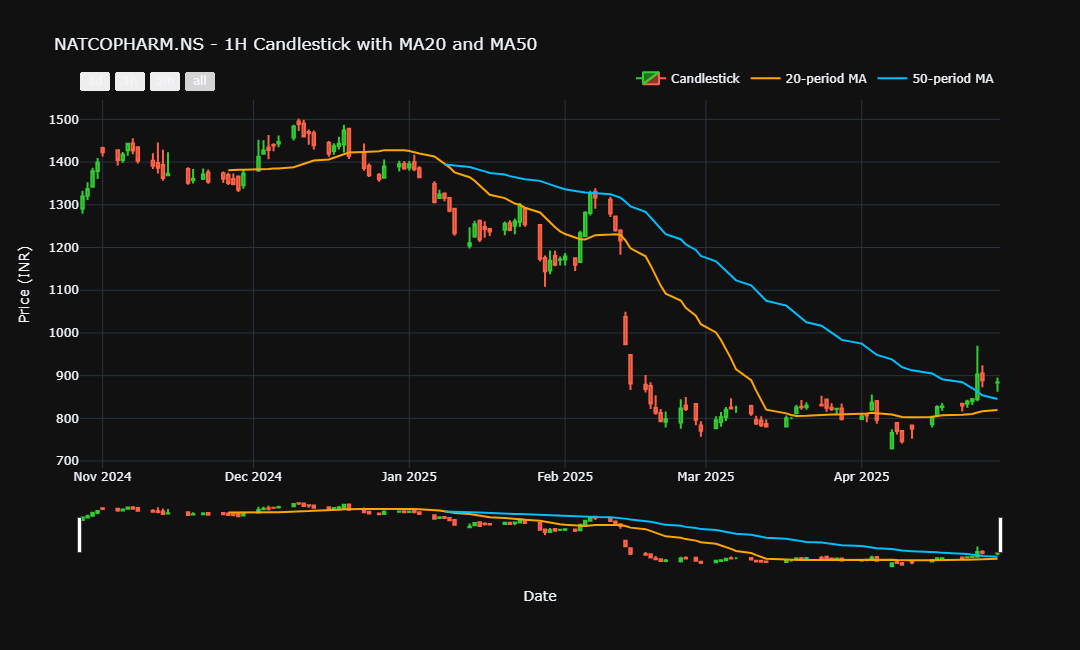

In [48]:
PATH = r"C:\Users\91909\Desktop\Stock_Data"

def save_to_csv_from_yahoo(ticker: str) -> bool:
    df = yf.download(ticker, period="6mo", progress=False)
    os.makedirs(PATH, exist_ok=True)
    fn = os.path.join(PATH, f"{ticker}.csv")
    df.to_csv(fn)
    return True

def get_stock_df_from_csv(ticker: str) -> pd.DataFrame:
    fn = os.path.join(PATH, f"{ticker}.csv")
    df = pd.read_csv(fn, index_col=0, parse_dates=True)
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

ticker = 'NATCOPHARM.NS'
save_to_csv_from_yahoo(ticker)
data = yf.download(ticker, period='6mo', interval='1h')
# Get data from CSV
data = get_stock_df_from_csv(ticker)

# Ensure data is not empty
if data.empty:
    print(f"No data found for {ticker}")
else:
    # Calculate Moving Averages
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()

    # Create a figure
    fig = go.Figure()

    fig.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Candlestick',
        increasing_line_color='limegreen',
        decreasing_line_color='tomato'
    ))
    fig.add_trace(go.Scatter(
        x=data.index,
        y=data['MA20'],
        mode='lines',
        name='20-period MA',
        line=dict(color='orange', width=2)
    ))
    fig.add_trace(go.Scatter(
        x=data.index,
        y=data['MA50'],
        mode='lines',
        name='50-period MA',
        line=dict(color='deepskyblue', width=2)
    ))
    fig.update_layout(
        title=f'{ticker} - 1H Candlestick with MA20 and MA50',
        xaxis_title='Date',
        yaxis_title='Price (INR)',
        template='plotly_dark',
        width=1100,
        height=650,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        hovermode='x unified'
    )

    # Add Range Slider and Buttons
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1h", step="hour", stepmode="backward"),
                dict(count=1, label="5m", step="minute", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    # Show plot
    fig.show()


# Exponential Moving Average

C:\Users\91909\AppData\Local\Temp\ipykernel_7596\1367120097.py:12: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



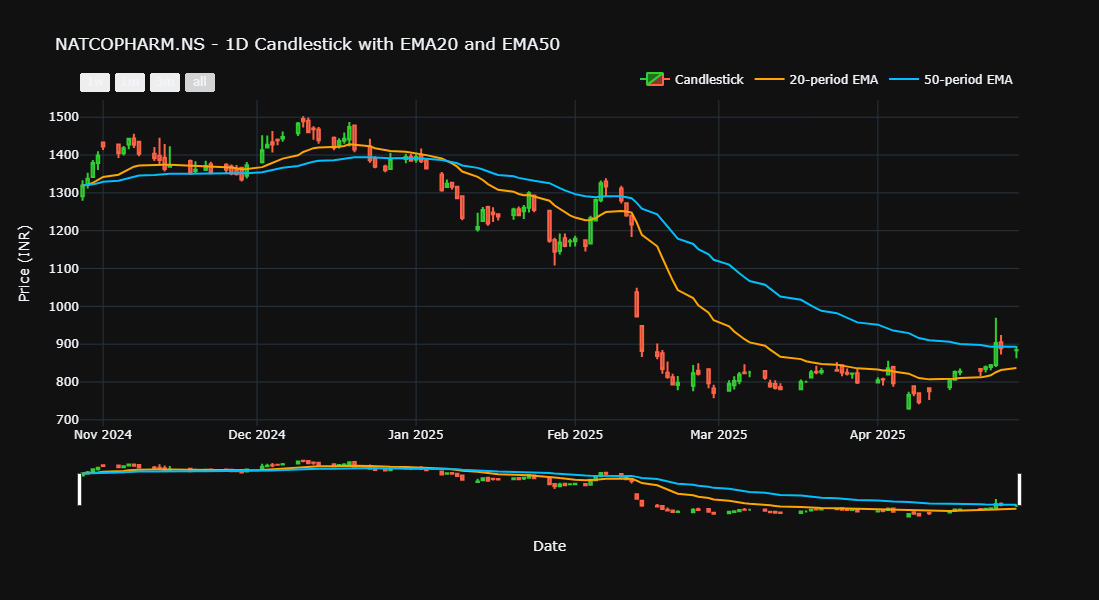

In [51]:
PATH = r"C:\Users\91909\Desktop\Stock_Data"

def save_to_csv_from_yahoo(ticker: str) -> bool:
    df = yf.download(ticker, period="6mo", progress=False)
    os.makedirs(PATH, exist_ok=True)
    fn = os.path.join(PATH, f"{ticker}.csv")
    df.to_csv(fn)
    return True

def get_stock_df_from_csv(ticker: str) -> pd.DataFrame:
    fn = os.path.join(PATH, f"{ticker}.csv")
    df = pd.read_csv(fn, index_col=0, parse_dates=True)
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

# Download and save data
ticker = 'NATCOPHARM.NS'
save_to_csv_from_yahoo(ticker)

# Get data from CSV
data = get_stock_df_from_csv(ticker)

# Calculate EMAs
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()

# Create the plot
fig = go.Figure()

# -----> No extra spaces here
fig.add_trace(go.Candlestick(
    x=data.index,
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close'],
    name='Candlestick',
    increasing_line_color='limegreen',
    decreasing_line_color='tomato'
))

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['EMA20'],
    mode='lines',
    name='20-period EMA',
    line=dict(color='orange', width=2)
))

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['EMA50'],
    mode='lines',
    name='50-period EMA',
    line=dict(color='deepskyblue', width=2)
))

# Layout settings
fig.update_layout(
    title=f'{ticker} - 1D Candlestick with EMA20 and EMA50',
    xaxis_title='Date',
    yaxis_title='Price (INR)',
    template='plotly_dark',
    width=1100,
    height=600,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    hovermode='x unified'
)

# Add Range Slider and Buttons
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)
# Show plot
fig.show()


# Death & Golden Crosses
When a Death Cross occurs, that is a sign that a major sell off will occur. A Death Cross is said to occur typically when the 50 day moving average falls below a 200 day. A Golden Cross accures when the short term average crosses the long term again moving higher.

In [61]:
def save_to_csv_from_yahoo(ticker: str) -> bool:
    df = yf.download(ticker, period="5y", progress=False)
    os.makedirs(PATH, exist_ok=True)
    fn = os.path.join(PATH, f"{ticker}.csv")
    df.to_csv(fn)
    print(f"Saved {fn}")
    return True
save_to_csv_from_yahoo("^NSEI")
nse_df = get_stock_df_from_csv("^NSEI")
nse_df

Saved C:\Users\91909\Desktop\Stock_Data\^NSEI.csv


C:\Users\91909\AppData\Local\Temp\ipykernel_7596\1367120097.py:12: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,Close,High,Low,Open,Volume
Price,,,,,
Ticker,NaN,NaN,NaN,NaN,NaN
Date,NaN,NaN,NaN,NaN,NaN
2020-04-28,9380.900391,9404.400391,9260.000000,9389.799805,614500.0
2020-04-29,9553.349609,9599.849609,9392.349609,9408.599609,653000.0
2020-04-30,9859.900391,9889.049805,9731.500000,9753.500000,931200.0
...,...,...,...,...,...
2025-04-22,24167.250000,24242.599609,24072.000000,24185.400391,440900.0
2025-04-23,24328.949219,24359.300781,24119.949219,24357.599609,415000.0
2025-04-24,24246.699219,24347.849609,24216.150391,24277.900391,358800.0


In [63]:
# SMA
nse_df['MA50'] = nse_df['Close'].rolling(50).mean()
nse_df['MA100'] = nse_df['Close'].rolling(100).mean()

# EMA If we set adjust to False the weighted function is calculated recursively
nse_df['EMA20'] = nse_df['Close'].ewm(span=20, adjust=False).mean()
nse_df['EMA50'] = nse_df['Close'].ewm(span=50, adjust=False).mean()
nse_df['EMA100'] = nse_df['Close'].ewm(span=100, adjust=False).mean()

nse_df

,Close,High,Low,Open,Volume,MA50,MA100,EMA20,EMA50,EMA100
Price,,,,,,,,,,
Ticker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-28,9380.900391,9404.400391,9260.000000,9389.799805,614500.0,NaN,NaN,9380.900391,9380.900391,9380.900391
2020-04-29,9553.349609,9599.849609,9392.349609,9408.599609,653000.0,NaN,NaN,9397.324126,9387.663105,9384.315227
2020-04-30,9859.900391,9889.049805,9731.500000,9753.500000,931200.0,NaN,NaN,9441.379008,9406.182214,9393.732755
...,...,...,...,...,...,...,...,...,...,...
2025-04-22,24167.250000,24242.599609,24072.000000,24185.400391,440900.0,23000.854062,23404.188066,23270.449100,23168.833081,23358.901824
2025-04-23,24328.949219,24359.300781,24119.949219,24357.599609,415000.0,23012.648047,23405.258555,23371.258635,23214.327832,23378.110683
2025-04-24,24246.699219,24347.849609,24216.150391,24277.900391,358800.0,23023.656016,23405.780547,23454.633929,23254.812984,23395.310456


# Plot Nifty50

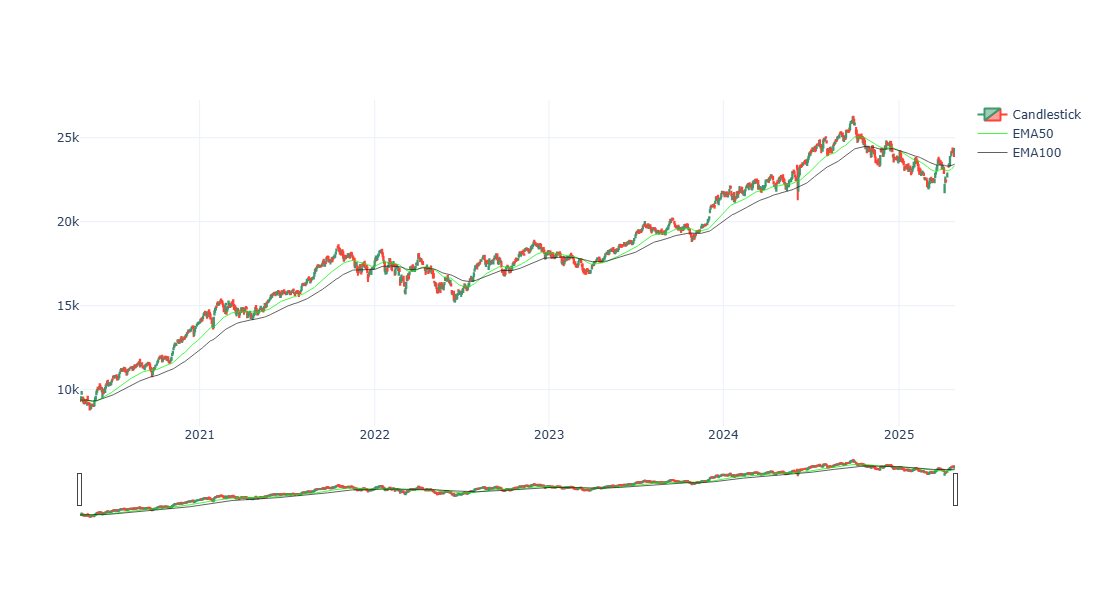

In [66]:
fig = go.Figure()

candle = go.Candlestick(x=nse_df.index, open=nse_df['Open'],
    high=nse_df['High'], low=nse_df['Low'],
    close=nse_df['Close'], name="Candlestick")

ema50_line = go.Scatter(x=nse_df.index, y=nse_df['EMA50'], 
    line=dict(color='rgba(0, 250, 0, 0.75)', 
    width=1), name="EMA50")

ema100_line = go.Scatter(x=nse_df.index, y=nse_df['EMA100'], 
    line=dict(color='rgba(30, 30, 30, 0.7)', 
    width=1), name="EMA100")

fig.add_trace(candle)
# 1st support line
fig.add_trace(ema50_line)
# 2nd support line
fig.add_trace(ema100_line)
fig.update_layout(
        template="plotly_white",
        height=600, width=1200,
        showlegend=True)
fig.update_xaxes(
  rangeslider_visible=True,
  rangebreaks=[dict(bounds=["sat","mon"])]
)
fig.show()


# Cufflinks Quant Figure Module

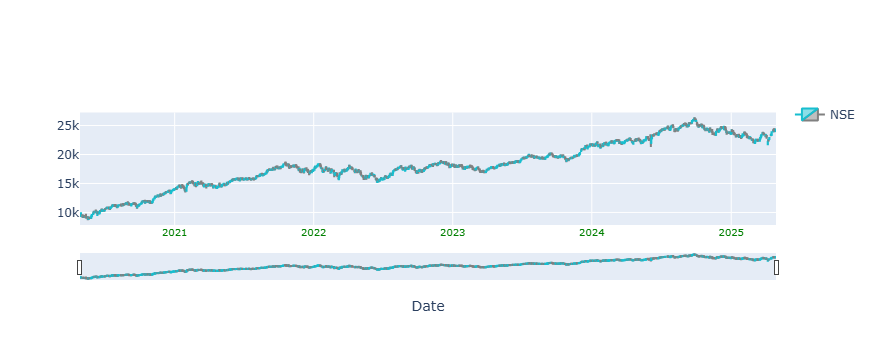

In [89]:
# add_sma - Simple Moving Average
# add_ema() - Exponential Moving Average
# add_trendline() - Trend line
# add_support() - Support line
# add_rsi - Relative Strength Indicator
# add_adx - Average Directional Index
# add_atr() - Average True Range
# add_macd() - Moving Average Convergence Divergence
# add_bollinger_bands - Bollinger Bands
# add_volume - Volume bars
# add_cci() - Commodity Channel Indicator
# add_dmi() - Directional Movement Index
# add_ptps() - Parabolic SAR
# add_resistance() - Resistance line


# qf=cf.QuantFig(nse_df, title='Nifty 50',legend='top',name='NSE')
# qf.add_bollinger_bands()
# qf.add_volume()

# qf.iplot()
qf = cf.QuantFig(nse_df, title='Nifty 50', legend='top', name='NSE',
                 layout={'xaxis': {'title': 'Date',
                                    'tickfont': {'size': 10, 'color': 'green'}}}
                                  )
qf.iplot()